## Task 2 Finding circles using Hough Transform
### The main function

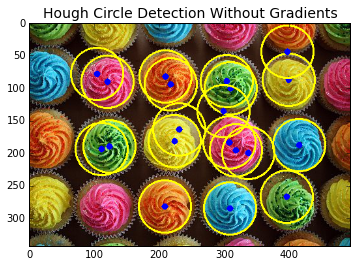

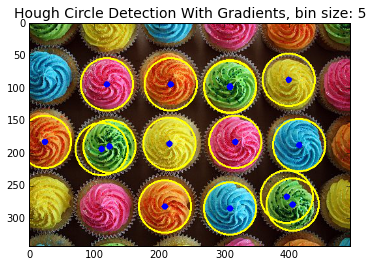

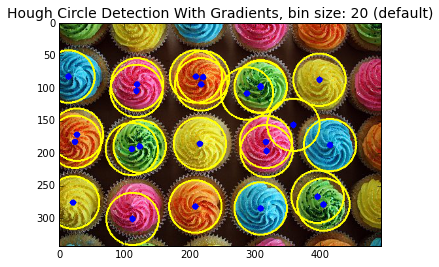

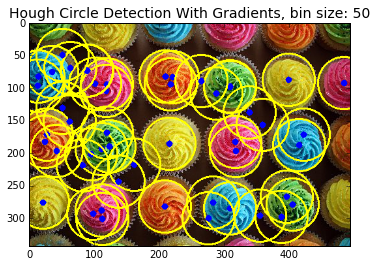

In [15]:
# Reference skimage source: https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/_hough_transform.pyx
# Reference opencv hough gradients: http://blog.csdn.net/wuyou_365/article/details/8124664
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage import color
from skimage.io import imread

A = cv2.imread('colorful3.jpg',0)
A_c = imread('colorful3.jpg')
A_d = A_c.copy()

def detectCircles(im,radius,usegradient,binsize = None):
    if binsize:
        bin_size = binsize
    else:
        bin_size = 20
        
    if usegradient:
        img = canny(im, sigma=3, low_threshold=10, high_threshold=50)
    else:
        img = canny(im,sigma=3, low_threshold=0, high_threshold=0)
        
    xmax = img.shape[0]
    ymax = img.shape[1]
    x, y = np.nonzero(img) #Return edge location
    num_pixels = x.size #number of 1
    acc = np.zeros((img.shape[0],img.shape[1]), dtype=np.double) 
    circle_x, circle_y = circle_perimeter(0, 0, radius) #circle edge location
    num_circle_pixels = circle_x.size
    for p in range(num_pixels): #Hough space
        for c in range(num_circle_pixels):
            tx = circle_x[c] + x[p] 
            ty = circle_y[c] + y[p]
            if 0 <= tx < xmax and 0 <= ty < ymax: 
                acc[tx, ty] += 1 #vote
    centers = peak_local_max(acc, num_peaks=bin_size)
    return centers

def drawCircles(im,centers,radius,st):
    image = im.copy()
    for idx in range(len(centers)):
        center_x, center_y = centers[idx]
        cv2.circle(image,(center_y,center_x),radius,(255,255,0),2)
        cv2.circle(image,(center_y,center_x),2,(0,0,255),6)
    plt.imshow(image)
    plt.title(st, fontsize=14)
    plt.show()


A_radius = 40
A_g = detectCircles(A,A_radius,False)
A_xg_1 = detectCircles(A,A_radius,True,15)
A_xg_2 = detectCircles(A,A_radius,True,25)
A_xg_3 = detectCircles(A,A_radius,True,50)
drawCircles(A_c,A_g,A_radius,'Hough Circle Detection Without Gradients')
drawCircles(A_d,A_xg_1,A_radius,'Hough Circle Detection With Gradients, bin size: 5')
drawCircles(A_d,A_xg_2,A_radius,'Hough Circle Detection With Gradients, bin size: 20 (default)')
drawCircles(A_d,A_xg_3,A_radius,'Hough Circle Detection With Gradients, bin size: 50')

### 2.1 Algorithm explaination 
Here are the steps of the Hough tramsform circle detection function:
1. load the image in both gray  (cv2.imread) and RGB color (skimage.io.imread). 
2. If there is a bin size parameter, set the bin size to it. If there isn't, bin size equals to default value, which is 20.
3. If usegradient is set to False, then set both low/high threshold in Canny to 0. Otherwise, set the low threshold to 10 and high to 50. 
4. Then use canny to do the edge detection and generat a binary image, where only edge has value "1" and others are 0
5. Therefore, use np.nonzero to get the edge location and also the number of "1"
6. Initiate the accumulator as the same size of the image.
7. Use circle_perimeter to generate the circle edge location 
8. In Hough space, add 1 to accumulator when the same the circle edge of the image edge appears. 
9. Get the highes several result from accumulator as the centers.( according to bin size )

### 2.3 With/without Gradient
Advantages of using the gradient:
    - The result of edge detection is much clearer, less pixels
Disadvantages: 
    - Much more pixels on the edge, which means it may takes longer to compute, and also uses memory.

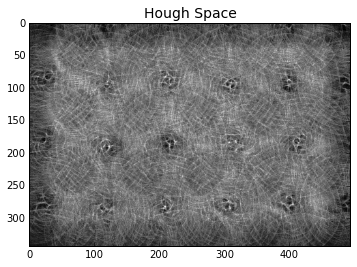

In [17]:
bin_size = 20
img = canny(A,sigma=3, low_threshold=0, high_threshold=0)

xmax = img.shape[0]
ymax = img.shape[1]
x, y = np.nonzero(img) #Return edge location
num_pixels = x.size #number of 1
acc = np.zeros((img.shape[0],img.shape[1]), dtype=np.double) 
circle_x, circle_y = circle_perimeter(0, 0, radius) #circle edge location
num_circle_pixels = circle_x.size
for p in range(num_pixels): #Hough space
    for c in range(num_circle_pixels):
        tx = circle_x[c] + x[p] 
        ty = circle_y[c] + y[p]
        if 0 <= tx < xmax and 0 <= ty < ymax: 
            acc[tx, ty] += 1 #vote
centers = peak_local_max(acc, num_peaks=bin_size)
plt.imshow(acc, cmap = cm.Greys_r)
plt.title('Hough Space', fontsize=14)
plt.show()

### 1.4 Hough Space
In Hough space, we can see clearly the intersection of different circular arcs. And the intersection has the most on the edge of circles. 

### 1.5 Different quantization/accumulator bin size
With large bin size, there is more vote but the resolution decreases. With smaller bin size, there isn't many high local maxima, but the resolution is high and clear.

### 1.6 Any radius
It is not circle detection really with any radius -- there will be a maximun and minimun value for radius. And also there will be one more for loop -- do the same circle ditection as discribed above with each radius value. 

In [19]:
def detectCircles(im,radius,usegradient):
    if usegradient:
        img = canny(im, sigma=3, low_threshold=10, high_threshold=50)
    else:
        img = canny(im,sigma=3, low_threshold=0, high_threshold=0)
    xmax = img.shape[0]
    ymax = img.shape[1]
    (rmin, rmax) = (40,80)
    x, y = np.nonzero(img) #Return edge position
    num_pixels = x.size #number of 1
    radius = np.arange(rmin, rmax) #min and max value for radius
    #accumulator for each pixel for each radius value
    acc = np.zeros((radius.size,img.shape[0],img.shape[1]), dtype=np.double) 
    for i, rad in enumerate(radius):
            # Store in memory the circle of given radius
            # centered at (0,0)
            circle_x, circle_y = circle_perimeter(0, 0, rad)
            num_circle_pixels = circle_x.size
            #num_circle_pixels ranges 200-400
            for p in range(num_pixels):
                    # Plug the circle at (px, py),
                    # its coordinates are (tx, ty)
                    for c in range(num_circle_pixels):
                        tx = circle_x[c] + x[p]
                        ty = circle_y[c] + y[p]
                        if 0 <= tx < xmax and 0 <= ty < ymax:
                            acc[i, tx, ty] += 1
    centers = []
    peaks = peak_local_max(acc, num_peaks=num_peaks)
    centers.extend(peaks)
    return centers

### 1.7 HT for Rectangles
After the peaks of the Hough image (which correspond to line segments) are extracted, a rectangle is detected when four extracted peaks satisfy certain geometric conditions because there would be two pairs of parallel lines.